# Data Preprocess

### Data Load

In [11]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [12]:
train_path = 'yoochoose-clicks.dat'
train_path

'yoochoose-clicks.dat'

In [13]:
def load_recent_data(data_path, cutoff_days=30):
    chunk_size = 5_000_000
    chunks = []

    print("📅 [1/3] 최신 날짜 찾는 중...")
    latest = None
    total_chunks = 0
    for i, chunk in enumerate(pd.read_csv(
        data_path,
        sep=',',
        header=None,
        usecols=[0, 1, 2],
        parse_dates=[1],
        dtype={0: np.int32, 2: np.int32},
        chunksize=chunk_size
    )):
        max_time = chunk[1].max()
        if latest is None or max_time > latest:
            latest = max_time
        total_chunks += 1
        print(f"  ▸ 최신 날짜 스캔 중... chunk {i+1} 완료")

    print(f"✅ 최신 날짜: {latest}")
    month_ago = latest - dt.timedelta(days=cutoff_days)
    print(f"📆 기준 날짜: {month_ago}")

    print("📦 [2/3] 최근 30일 데이터 필터링 중...")
    matched_rows = 0
    for i, chunk in enumerate(pd.read_csv(
        data_path,
        sep=',',
        header=None,
        usecols=[0, 1, 2],
        parse_dates=[1],
        dtype={0: np.int32, 2: np.int32},
        chunksize=chunk_size
    )):
        chunk.columns = ['SessionId', 'Time', 'ItemId']
        filtered = chunk[chunk['Time'] > month_ago]
        matched_rows += len(filtered)
        if not filtered.empty:
            chunks.append(filtered)
        print(f"  ▸ chunk {i+1} 처리 완료 ({len(filtered)}개 매치됨)")

    data = pd.concat(chunks, ignore_index=True)

    print("🎉 [3/3] 필터링 완료")
    print(f"🧾 최종 데이터 크기: {len(data):,} rows")

    return data

In [14]:
data = load_recent_data(train_path)
data.sort_values(['SessionId', 'Time'], inplace=True)

📅 [1/3] 최신 날짜 찾는 중...
  ▸ 최신 날짜 스캔 중... chunk 1 완료
  ▸ 최신 날짜 스캔 중... chunk 2 완료
  ▸ 최신 날짜 스캔 중... chunk 3 완료
  ▸ 최신 날짜 스캔 중... chunk 4 완료
  ▸ 최신 날짜 스캔 중... chunk 5 완료
  ▸ 최신 날짜 스캔 중... chunk 6 완료
  ▸ 최신 날짜 스캔 중... chunk 7 완료
✅ 최신 날짜: 2014-09-30 02:59:59.430000+00:00
📆 기준 날짜: 2014-08-31 02:59:59.430000+00:00
📦 [2/3] 최근 30일 데이터 필터링 중...
  ▸ chunk 1 처리 완료 (0개 매치됨)
  ▸ chunk 2 처리 완료 (0개 매치됨)
  ▸ chunk 3 처리 완료 (0개 매치됨)
  ▸ chunk 4 처리 완료 (0개 매치됨)
  ▸ chunk 5 처리 완료 (0개 매치됨)
  ▸ chunk 6 처리 완료 (2637457개 매치됨)
  ▸ chunk 7 처리 완료 (3003944개 매치됨)
🎉 [3/3] 필터링 완료
🧾 최종 데이터 크기: 5,641,401 rows


In [15]:
data

,SessionId,Time,ItemId
126221,9194111,2014-08-31 17:40:46.805000+00:00,214853420
126222,9194111,2014-08-31 17:42:26.089000+00:00,214850942
126223,9194111,2014-08-31 17:44:06.583000+00:00,214829878
126224,9194111,2014-08-31 17:48:49.873000+00:00,214853420
126317,9194112,2014-09-01 13:26:36.292000+00:00,214853422
...,...,...,...
4867944,11562158,2014-09-26 04:50:29.172000+00:00,214849132
4867945,11562158,2014-09-26 04:52:21.900000+00:00,214854774
4867946,11562158,2014-09-26 05:16:32.904000+00:00,214849132
4867947,11562159,2014-09-26 19:16:28.897000+00:00,214849132


### Session Length

In [16]:
session_length = data.groupby('SessionId').size() # 각 세션이 대략 몇 개의 클릭 데이터를 갖는지
session_length

SessionId
9194111     4
9194112     1
9194123     3
9194124     2
9194126     1
           ..
11562156    2
11562157    2
11562158    3
11562159    1
11562161    1
Length: 1639032, dtype: int64

In [17]:
session_length.median(), session_length.mean()

(2.0, 3.441910225059669)

In [18]:
session_length.min(), session_length.max()

(1, 200)

In [19]:
session_length.quantile(0.999)

41.0

In [20]:
long_session = session_length[session_length==200].index[0]
data[data['SessionId']==long_session]

,SessionId,Time,ItemId
1497718,9781279,2014-09-05 12:36:09.590000+00:00,214534211
1497719,9781279,2014-09-05 12:36:14.493000+00:00,214680463
1497720,9781279,2014-09-05 12:36:18.288000+00:00,214587193
1497721,9781279,2014-09-05 12:36:29.075000+00:00,214834978
1497722,9781279,2014-09-05 12:37:59.583000+00:00,214684755
...,...,...,...
1497913,9781279,2014-09-05 15:48:45.346000+00:00,214565557
1497914,9781279,2014-09-05 15:48:55.612000+00:00,214585406
1497915,9781279,2014-09-05 15:49:06.494000+00:00,214581444
1497916,9781279,2014-09-05 15:49:08.383000+00:00,214565535


In [21]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

1     0.220500
2     0.556013
3     0.708616
4     0.802125
5     0.856219
6     0.894427
7     0.918897
8     0.937228
9     0.949918
10    0.959849
11    0.967048
12    0.972919
13    0.977373
14    0.981030
15    0.983903
16    0.986304
17    0.988186
18    0.989821
19    0.991083
20    0.992187
21    0.993125
22    0.993929
23    0.994665
24    0.995272
25    0.995760
26    0.996192
27    0.996590
28    0.996934
29    0.997228
30    0.997495
31    0.997723
32    0.997937
33    0.998112
34    0.998264
35    0.998401
36    0.998541
37    0.998655
38    0.998757
39    0.998857
40    0.998944
dtype: float64

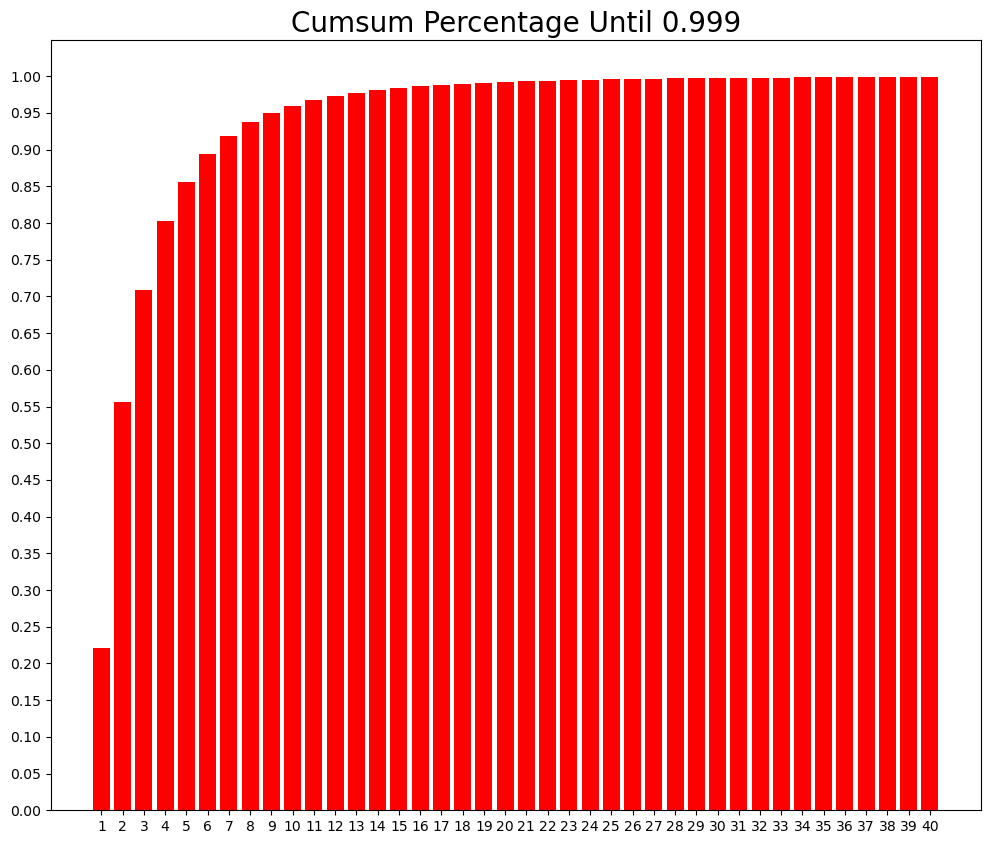

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

### Session Time

In [23]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest)
print(latest)

2014-08-31 03:00:01.111000+00:00
2014-09-30 02:59:59.430000+00:00


In [24]:
type(latest)
# latest는 Timestamp 객체이기 때문에 int 객체와의 사칙연산을 지원하지 않는다.
# 날짜끼리의 차이를 구하고 싶을 때는 datetime 라이브러리의 timedelta 객체를 사용

pandas._libs.tslibs.timestamps.Timestamp

In [25]:
month_ago = latest - dt.timedelta(30)     # 최종 날짜로부터 30일 이전 날짜를 구한다.  
data = data[data['Time'] > month_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
data # 한 달 치 데이터 

,SessionId,Time,ItemId
126221,9194111,2014-08-31 17:40:46.805000+00:00,214853420
126222,9194111,2014-08-31 17:42:26.089000+00:00,214850942
126223,9194111,2014-08-31 17:44:06.583000+00:00,214829878
126224,9194111,2014-08-31 17:48:49.873000+00:00,214853420
126317,9194112,2014-09-01 13:26:36.292000+00:00,214853422
...,...,...,...
4867944,11562158,2014-09-26 04:50:29.172000+00:00,214849132
4867945,11562158,2014-09-26 04:52:21.900000+00:00,214854774
4867946,11562158,2014-09-26 05:16:32.904000+00:00,214849132
4867947,11562159,2014-09-26 19:16:28.897000+00:00,214849132


### Data Cleansing 데이터 정제
- 한 세션에서 2번 이상 클릭안한 제품을 제거: 추천 정확도 향상
- 전체에서 5번이상 클릭 안한 제품을 제거: 평가 기준 충족

In [26]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생김 
# 이를 위해 반복문을 통해 지속적으로 제거

# 전체 데이터 클렌징을 반복 수행하는 함수
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


# 너무 짧은 세션 제거
def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data


# 너무 적게 클릭된 아이템 제거
def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [27]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,SessionId,Time,ItemId
126221,9194111,2014-08-31 17:40:46.805000+00:00,214853420
126222,9194111,2014-08-31 17:42:26.089000+00:00,214850942
126223,9194111,2014-08-31 17:44:06.583000+00:00,214829878
126224,9194111,2014-08-31 17:48:49.873000+00:00,214853420
126314,9194123,2014-08-31 19:26:57.386000+00:00,214601207
...,...,...,...
4867942,11562157,2014-09-25 12:31:10.391000+00:00,214580372
4867943,11562157,2014-09-25 12:31:29.679000+00:00,214516012
4867944,11562158,2014-09-26 04:50:29.172000+00:00,214849132
4867945,11562158,2014-09-26 04:52:21.900000+00:00,214854774


### Train / Valid / Test split

In [28]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [29]:
tr, test = split_by_date(data, n_days=1)
tr, val = split_by_date(tr, n_days=1)

In [30]:
# 정보 확인하는 함수
def stats_info(data: pd.DataFrame, status: str): 
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [31]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 5125100
	 Sessions: 1243431
	 Items: 20153
	 First Time : 2014-08-31 03:00:01.111000+00:00
	 Last Time : 2014-09-28 02:57:34.348000+00:00

* valid Set Stats Info
	 Events: 58074
	 Sessions: 12350
	 Items: 6232
	 First Time : 2014-09-28 03:00:25.298000+00:00
	 Last Time : 2014-09-29 02:58:27.660000+00:00

* test Set Stats Info
	 Events: 71009
	 Sessions: 15289
	 Items: 6580
	 First Time : 2014-09-29 02:37:20.695000+00:00
	 Last Time : 2014-09-30 02:59:59.430000+00:00



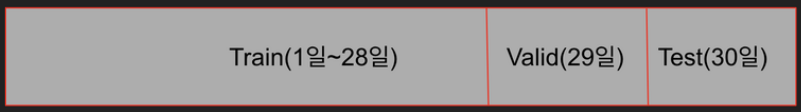

In [32]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [33]:
tr, test = split_by_date(data, n_days=1)
tr, val = split_by_date(tr, n_days=1)

In [35]:
# data에 대한 정보를 살펴본다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [36]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 5125100
	 Sessions: 1243431
	 Items: 20153
	 First Time : 2014-08-31 03:00:01.111000+00:00
	 Last Time : 2014-09-28 02:57:34.348000+00:00

* valid Set Stats Info
	 Events: 58074
	 Sessions: 12350
	 Items: 6232
	 First Time : 2014-09-28 03:00:25.298000+00:00
	 Last Time : 2014-09-29 02:58:27.660000+00:00

* test Set Stats Info
	 Events: 71009
	 Sessions: 15289
	 Items: 6580
	 First Time : 2014-09-29 02:37:20.695000+00:00
	 Last Time : 2014-09-30 02:59:59.430000+00:00



In [38]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해준다. 
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [40]:
save_path = Path('./processed')
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## Data Pipeline

### SessionDataset

train데이터로 SessionDataset 객체를 만들고 인스턴스 변수들을 살펴보자.  
click_offsets 변수는 각 세션이 시작된 인덱스를 담고 있다.  
session_idx 변수는 각 세션을 인덱싱한 np.array이다.  

In [41]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

In [42]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,SessionId,Time,ItemId,item_idx
126221,9194111,2014-08-31 17:40:46.805000+00:00,214853420,0
126222,9194111,2014-08-31 17:42:26.089000+00:00,214850942,1
126223,9194111,2014-08-31 17:44:06.583000+00:00,214829878,2
126224,9194111,2014-08-31 17:48:49.873000+00:00,214853420,0
126314,9194123,2014-08-31 19:26:57.386000+00:00,214601207,3
126315,9194123,2014-08-31 19:34:37.068000+00:00,214510689,4
126308,9194124,2014-08-31 19:14:28.308000+00:00,214849327,5
126309,9194124,2014-08-31 19:16:31.114000+00:00,214828970,6
126311,9194127,2014-09-01 15:36:11.651000+00:00,214845997,7
126312,9194127,2014-09-01 15:38:00.222000+00:00,214845997,7


In [43]:
tr_dataset.click_offsets

array([      0,       4,       6, ..., 5125095, 5125097, 5125100])

In [44]:
tr_dataset.session_idx

array([      0,       1,       2, ..., 1243428, 1243429, 1243430])

### SessionDataLoader

`SessionDataset` 객체를 받아서 Session-Parallel mini-batch를 만드는 클래스를 만든다.  
`__iter__` 메서드는 모델 인풋, 라벨, 세션이 끝나는 곳의 위치를 `yield`한다.  
mask는 후에 RNN Cell State를 초기화하는데 사용한다.  

In [45]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져온다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둔다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져온다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져온다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해준다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수이다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):
        # 다음 배치 데이터를 생성하기 위해 상태를 update한다.

        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해준다.
        mask = np.arange(self.batch_size)[(end - start) == 1]
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해준다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 둔다.
            new_session = last_session + i
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록한다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둔다.
        return start, end, mask, last_session, finished

In [46]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,SessionId,Time,ItemId,item_idx
126221,9194111,2014-08-31 17:40:46.805000+00:00,214853420,0
126222,9194111,2014-08-31 17:42:26.089000+00:00,214850942,1
126223,9194111,2014-08-31 17:44:06.583000+00:00,214829878,2
126224,9194111,2014-08-31 17:48:49.873000+00:00,214853420,0
126314,9194123,2014-08-31 19:26:57.386000+00:00,214601207,3
126315,9194123,2014-08-31 19:34:37.068000+00:00,214510689,4
126308,9194124,2014-08-31 19:14:28.308000+00:00,214849327,5
126309,9194124,2014-08-31 19:16:31.114000+00:00,214828970,6
126311,9194127,2014-09-01 15:36:11.651000+00:00,214845997,7
126312,9194127,2014-09-01 15:38:00.222000+00:00,214845997,7


In [47]:
iter_ex = iter(tr_data_loader)

In [48]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [0 3 5 7]
Label Item Idx are :       [1 4 6 7]
Previous Masked Input Idx are []


## Modeling

### Evaluation Metric 성능 지표

In [49]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### Model Architecture

In [50]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [53]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [54]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=2048, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [55]:
model = create_model(args)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (2048, 1, 20153)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GRU (GRU)                            │ [(2048, 50), (2048, 50)]    │       3,030,750 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (2048, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (2048, 20153)               │       1,027,803 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,058,553 (15.48 MB)

 Trainable params: 4,058,553 (15.48 MB)

 Non-trainable params: 0 (0.00 B)

### Model Training

In [60]:
# train 셋으로 학습하면서 valid 셋으로 검증한다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화. 

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


# def reset_hidden_states(model, mask):
#     gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져온다.
#     hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져온다.
#     for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
#         hidden_states[elt, :] = 0  # parameter를 초기화.
#     gru_layer.reset_states(states=hidden_states)

def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')
    gru_layer.reset_states()  # 내부 hidden state 전체 초기화


## 모델을 가져오는 과정에서 수정이 필요하다.
def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()

    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        # pred = model(input_ohe, training=False)

        # # 🔥 dict이면 첫 번째 값만 추출
        # if isinstance(pred, dict):
        #     pred = list(pred.values())[0]

        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 한다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [61]:
from keras.layers import TFSMLayer

# ## colab에서 하면 keras 모델을 불러오는 방법이 달라집니다 load model을 하려면 keras 로 저장했어야하는데 h5 형태이기때문
# model = TFSMLayer(
#     "/content/drive/MyDrive/Colab Notebooks/데싸4기/추천시스템/data/trained_model",
#     call_endpoint="serving_default"  # 보통 이 이름이 맞지만 다른 경우도 있음
# )

In [62]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:   0%|                                                                               | 0/27 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step


Evaluation:   4%|██▋                                                                    | 1/27 [00:28<12:31, 28.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


Evaluation:   7%|█████▎                                                                 | 2/27 [01:09<14:48, 35.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


Evaluation:  11%|███████▉                                                               | 3/27 [01:45<14:18, 35.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


Evaluation:  15%|██████████▌                                                            | 4/27 [02:27<14:44, 38.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


Evaluation:  19%|█████████████▏                                                         | 5/27 [03:09<14:30, 39.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


Evaluation:  22%|███████████████▊                                                       | 6/27 [03:57<14:50, 42.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


Evaluation:  26%|██████████████████▍                                                    | 7/27 [04:31<13:15, 39.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


Evaluation:  30%|█████████████████████                                                  | 8/27 [05:12<12:45, 40.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


Evaluation:  33%|███████████████████████▋                                               | 9/27 [05:45<11:20, 37.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


Evaluation:  37%|█████████████████████████▉                                            | 10/27 [06:24<10:52, 38.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


Evaluation:  41%|████████████████████████████▌                                         | 11/27 [07:16<11:16, 42.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step


Evaluation:  44%|███████████████████████████████                                       | 12/27 [08:11<11:33, 46.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


Evaluation:  48%|█████████████████████████████████▋                                    | 13/27 [09:08<11:32, 49.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


Evaluation:  52%|████████████████████████████████████▎                                 | 14/27 [10:21<12:15, 56.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step


Evaluation:  56%|██████████████████████████████████████▉                               | 15/27 [11:10<10:52, 54.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


Evaluation:  59%|█████████████████████████████████████████▍                            | 16/27 [11:40<08:37, 47.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


Evaluation:  63%|████████████████████████████████████████████                          | 17/27 [12:10<06:59, 41.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


Evaluation:  67%|██████████████████████████████████████████████▋                       | 18/27 [12:40<05:43, 38.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


Evaluation:  70%|█████████████████████████████████████████████████▎                    | 19/27 [13:09<04:44, 35.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


Evaluation:  74%|███████████████████████████████████████████████████▊                  | 20/27 [13:38<03:54, 33.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


Evaluation:  78%|██████████████████████████████████████████████████████▍               | 21/27 [14:06<03:10, 31.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


Evaluation:  81%|█████████████████████████████████████████████████████████             | 22/27 [14:34<03:18, 39.74s/it]

	 - Recall@20: 0.000355
	 - MRR@20: 0.000056

